## Tic-Tac-Toe Agent
​
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:
        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
# from <TC_Env> import <TicTacToe> - import your class from environment file
from TCGame_Env1 import TicTacToe
import collections
import numpy as np
import random
import pickle
import time
from matplotlib import pyplot as plt

In [2]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [3]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):
    valid_Actions = []  
    valid_Actions = [i for i in env.action_space(state)[0]] ###### -------please call your environment as env
    return valid_Actions

In [4]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state) 
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [5]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy
def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*time)
    z = np.random.random()
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
    else:
        agent_actions, env_actions = env.action_space(state)
        action = random.choice(list(agent_actions))           #Exploration: randomly choosing and action
    return action

#### Tracking the state-action pairs for checking convergence - write your code here

In [6]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)
print(len(Q_dict))
print(len(States_track))

0
0


In [7]:
# Initialise states to be tracked
def initialise_tracking_states():
    ##select any 4 Q-values
    sample_q_values = [('x-x-x-x-x-x-x-x-x',(0,9)),('x-x-x-x-x-x-x-x-x',(1,5)),('x-x-x-x-x-x-x-x-x',(2,3)),('x-x-x-x-x-x-x-x-x',(1,7))]
    for q_value in sample_q_values:
        state = q_value[0]
        action = q_value[1]
        States_track[state][action] = []     #this is an array which will have appended values of that state-action pair for every th episode

In [8]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [9]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [10]:
initialise_tracking_states()

### Define hyperparameters  ---write your code here


- We are running it for 3 millions episode with threshold as 50k.
- Not running for more episodes as it gets stuck.

In [11]:
EPISODES = 3000000
#EPISODES = 20
LR = 0.05                   #learning rate
GAMMA = 0.91

max_epsilon = 1.0
min_epsilon = 0.001

threshold = 50000          #every these many episodes, the 4 Q-values will be stored/appended (convergence graphs)
#threshold = 1
policy_threshold = 50000   #every these many episodes, the Q-dict will be updated
#policy_threshold = 3

### Q-update loop ---write your code here

In [12]:
start_time = time.time()

for episode in range(EPISODES):
    ##### Start writing your code from the next line
    env = TicTacToe()                #creating an instance of the class
    curr_state = env.state
    isTerminated = False             # flag variable is true when game ends.
    add_to_dict(curr_state)          # Add initial state to Q_dict
    total_reward = 0

    while not isTerminated:
        current_state_q = Q_state(curr_state)
        curr_action = epsilon_greedy(curr_state, episode)
        # step function returns the next state, reward and whether the state is terminal
        next_state, reward, isTerminated = env.step(curr_state, curr_action)
        next_state_q = Q_state(next_state)
        # Add next state to add_dict
        add_to_dict(next_state)

        if isTerminated:
            # if game is completed update q value of current state
            Q_dict[current_state_q][curr_action] += LR * (
                (reward - Q_dict[current_state_q][curr_action]))
        else:
            # if game is not completed, update q value of current state using next state and q value equation
            # this gets the action corresponding to max q-value of next state
            max_next = max(Q_dict[next_state_q],                   
                           key=Q_dict[next_state_q].get)
            Q_dict[current_state_q][curr_action] += LR * (
                (reward + (GAMMA * (Q_dict[next_state_q][max_next]))) -
                Q_dict[current_state_q][curr_action])
        # next state is assigned to current state for next moves
        curr_state = next_state
        # add up total reward agent has accumulated 
        total_reward += reward

    #TRACKING Q-VALUES
    if (episode == threshold-1):        #at the 49999th episode
        initialise_tracking_states()
    # Save the state action pair Q values every 50000th episode
    if ((episode+1) % threshold) == 0:   #every 50000th episode
        save_tracking_states()
        save_obj(States_track,'States_tracked')

    #SAVING POLICY
    if ((episode+1)% policy_threshold ) == 0:             #every 50000th episodes, the Q-dict will be saved
        save_obj(Q_dict,'Policy')
           
elapsed_time = time.time() - start_time
save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')
print("elapsed_time:",elapsed_time)

elapsed_time: 3240.8859808444977


### Check the Q-dictionary

In [13]:
Q_dict

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 1): 2.5816400271524795,
              (0, 3): 2.8891119233034708,
              (0, 5): 0.2676428015729176,
              (0, 7): 2.53634131933138,
              (0, 9): 3.2143100355629786,
              (1, 1): -0.2507621157049433,
              (1, 3): 0.12689466461486676,
              (1, 5): 5.648111616994991,
              (1, 7): 0.4393664473595632,
              (1, 9): 0.22830278055617673,
              (2, 1): 1.7530093586445261,
              (2, 3): 1.6094882535066208,
              (2, 5): 0.08112881519559875,
              (2, 7): 2.3306451999446756,
              (2, 9): 2.644155690507257,
              (3, 1): 0.6682390211910774,
              (3, 3): 1.0599499786536097,
              (3, 5): 0.6746949423366805,
              (3, 7): 0.8365458603127496,
              (3, 9): 1.1818874294098993,
              (4, 1): 1.1521292566892185,
              (4, 3): 1.602824540253868,
              (4, 5): -1.4215024929759

In [14]:
len(Q_dict)

1685892

- Lets check for one of the values from Q_dict

In [15]:
Q_dict['x-x-x-x-x-x-x-x-x']

{(0, 1): 2.5816400271524795,
 (0, 3): 2.8891119233034708,
 (0, 5): 0.2676428015729176,
 (0, 7): 2.53634131933138,
 (0, 9): 3.2143100355629786,
 (1, 1): -0.2507621157049433,
 (1, 3): 0.12689466461486676,
 (1, 5): 5.648111616994991,
 (1, 7): 0.4393664473595632,
 (1, 9): 0.22830278055617673,
 (2, 1): 1.7530093586445261,
 (2, 3): 1.6094882535066208,
 (2, 5): 0.08112881519559875,
 (2, 7): 2.3306451999446756,
 (2, 9): 2.644155690507257,
 (3, 1): 0.6682390211910774,
 (3, 3): 1.0599499786536097,
 (3, 5): 0.6746949423366805,
 (3, 7): 0.8365458603127496,
 (3, 9): 1.1818874294098993,
 (4, 1): 1.1521292566892185,
 (4, 3): 1.602824540253868,
 (4, 5): -1.4215024929759967,
 (4, 7): 1.1979555842224041,
 (4, 9): 1.721467606580844,
 (5, 1): -0.30489747603617706,
 (5, 3): -0.5386595473960052,
 (5, 5): -0.6368132228809597,
 (5, 7): 0.1741014424854807,
 (5, 9): 0.08782924278708545,
 (6, 1): 0.4382086685146488,
 (6, 3): 0.5400513541749365,
 (6, 5): 0.04742906207542602,
 (6, 7): 0.9938459064426718,
 (6, 9): 

#### try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [16]:
States_track

defaultdict(dict,
            {'x-x-x-x-x-x-x-x-x': {(0, 9): [-0.9999999999999989,
               -1.0199083482610731,
               -1.067687729242615,
               -1.1228327841780832,
               -1.1802214922511756,
               -1.2316721968532167,
               -1.2808430697911128,
               -1.3247035671735632,
               -1.3658887231389605,
               -1.3985322859273857,
               -1.4368413466161876,
               -1.4702459609544545,
               -1.4022938842527548,
               -1.1226562426883078,
               -0.9464157937578838,
               -0.9419518660669995,
               -0.3886507284030941,
               -0.41632579529458197,
               0.4451074853217495,
               0.8467823046269133,
               -0.09750644873906524,
               0.6007125369654289,
               0.8674923556406061,
               0.6518003382269363,
               1.4321000638468186,
               1.6402476009352027,
               1.811814

In [17]:
# Write the code for plotting the graphs for state-action pairs tracked
with open('States_tracked.pkl', 'rb') as handle:
    States_track = pickle.load(handle)

### Plots for state-action pairs tracked

- Looking at below plots we can say that agent was able to learn(converge) for some state action pairs and q-values increased slowly-slowly with number of episodes.

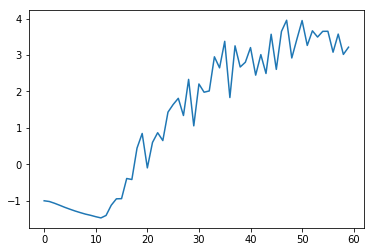

In [18]:
x=np.arange(len(States_track['x-x-x-x-x-x-x-x-x'][(0,9)]))
y=np.array(States_track['x-x-x-x-x-x-x-x-x'][(0,9)])
plt.plot(x,y)
plt.show()

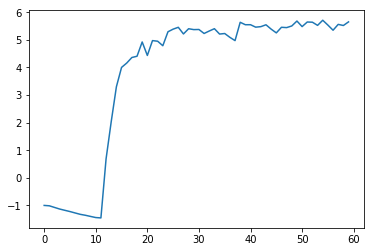

In [19]:
x=np.arange(len(States_track['x-x-x-x-x-x-x-x-x'][(1,5)]))
y=np.array(States_track['x-x-x-x-x-x-x-x-x'][(1,5)])
plt.plot(x,y)
plt.show()

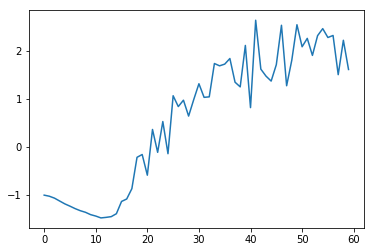

In [20]:
x=np.arange(len(States_track['x-x-x-x-x-x-x-x-x'][(2,3)]))
y=np.array(States_track['x-x-x-x-x-x-x-x-x'][(2,3)])
plt.plot(x,y)
plt.show()

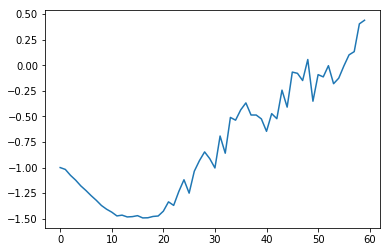

In [21]:
x=np.arange(len(States_track['x-x-x-x-x-x-x-x-x'][(1,7)]))
y=np.array(States_track['x-x-x-x-x-x-x-x-x'][(1,7)])
plt.plot(x,y)
plt.show()

### Epsilon - decay check

In [22]:
max_epsilon = 1.0
min_epsilon = 0.001
time = np.arange(0,3000000)
epsilon = []
for i in range(0,3000000):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-0.000001*i))

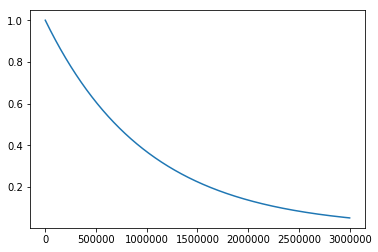

In [23]:
plt.plot(time, epsilon)
plt.show()